The German Credit data set is a publically available data set downloaded from the UCI Machine Learning Repository. The data contains data on 20 variables and the classification whether an applicant is considered a Good or a Bad credit risk for 1000 loan applicants.

### [Data Source](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data))

### Benchmark
![Credit Risk Classification: Faster Machine Learning with Intel Optimized Packages](https://i.imgur.com/nL1l7WI.png)

according to [1] the best model is Random Forest with balanced feature selection data. it's has Accuracy 82%, Precision 84%, Recall 82% and F1-Score 81%. 

<br>


The goal of this kernel is to beat The benchmark with  :
- Convert dataset to Machine Learning friendly (Feature Engginering)
- Develop XGBoost model to predict whether a loan is a good or bad risk.
- Find the Best parameter for XGBoost Model (Hyperparameter Tunning)
- Beat the Benchmark

# Table of Content

**1. [Introduction](#Introduction)** <br>
    - Import Library
    - Evaluation Function
    - XGBoost Model

**2. [Preprocess, creation of new variables and EDA](#Preprocess)** <br>
    - Importing Dataset
    - Features and variables engineering
    - Exploratory Data Analysis
    - StandardScaler
    - Encoding Categorical Feature
    - Concate Transformed Dataset
    - Split Training Dataset
    - XGBoost  1a: Unbalance Dataset (Base Model: ROC_AUC:0.74)
    - XGBoost  1b: Unbalance Dataset (ROC_AUC:0.79)

**3. [Balanced Dataset](#Balanced Dataset)** <br>    
    - XGBoost 2a: Balanced (Base Model: ROC_AUC:0.77)
    - **XGBoost 2b: Balanced (ROC_AUC:0.80)**

**4. [Others](#Others)** <br>  
    - Lighgbm (ROC_AUC:0.73)
    - LogisticRegression (ROC_AUC:0.75)
    - RandomForestClassifier (ROC_AUC:0.80)
    - ExtraTreesClassifier (ROC_AUC:0.79)
    - DecisionTreeClassifier (ROC_AUC:0.69)
    - GradientBoostingClassifier (ROC_AUC:0.80)
    - AdaBoostClassifier (ROC_AUC:0.78)
    - Tuning of Random Forest with RandomizedSearch
    - Tuning of Gradiend Boosting with RandomizedSearch

<a id="Introduction"></a> <br>
# **1. Introduction:** 
- Import Library
- Evaluation Function
- XGBoost Model

### Import Library

In [1]:
#Importing necessary packages in Python 
%matplotlib inline 
import matplotlib.pyplot as plt 

import numpy as np ; np.random.seed(sum(map(ord, "aesthetics")))
import pandas as pd

from sklearn.datasets import make_classification 
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import ShuffleSplit,train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler

import seaborn 
seaborn.set_context('notebook') 
seaborn.set_style(style='darkgrid')

from pprint import pprint 
 


### Evaluation Function


In [2]:
# Function for evaluation reports
def get_eval1(clf, X,y):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X, y, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X, y, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X, y, cv=2, scoring='roc_auc')
    
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return 


In [3]:
def get_eval2(clf, X_train, y_train,X_test, y_test):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_test, y_test, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X_test, y_test, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X_test, y_test, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X_test, y_test, cv=2, scoring='roc_auc')
    
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return 

In [4]:
# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="upper left")
    plt.show()
    return

#### XGBoost Model

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import xgboost as xgb
from xgboost import XGBClassifier

In [6]:
def plot_featureImportance(model, keys):
    importances = model.feature_importances_
    importance_frame = pd.DataFrame({'Importance': list(importances), 'Feature': list(keys)})
    importance_frame.sort_values(by = 'Importance', inplace = True)
    importance_frame.tail(10).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

In [7]:
def xgb_classifier(params, X_train, y_train, X_test, y_test):
    """
    Trains and evaluates an XGBoost classifier based on the provided parameters and datasets.
    
    Args:
        params (dict): Parameters for the XGBoost classifier.
        X_train (DataFrame): Training data features.
        y_train (Series): Training data labels.
        X_test (DataFrame): Test data features.
        y_test (Series): Test data labels.
        
    Returns:
        model (XGBClassifier): Trained XGBoost classifier model.
    """
    # Update parameters to include evaluation metrics and early stopping conditions
    updated_params = params.copy()  # Make a copy to avoid modifying the external original
    updated_params['eval_metric'] = 'auc'
    updated_params['early_stopping_rounds'] = 100
    
    # Create the model with the updated parameters
    model = XGBClassifier(**updated_params)
    
    # Train the model with evaluation sets
    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_set=eval_set, verbose=100)
    
    # Update the number of estimators to the best found during training if necessary
    if model.best_iteration > 0:
        model.set_params(n_estimators=model.best_iteration)
    else:
        # Retrain if no improvement was found
        model.fit(X_train, y_train)
    
    # Make predictions and evaluate the model
    y_pred = model.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion_mat)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"\nFinal Model Generalization Accuracy: {accuracy_score(y_test, y_pred):.6f}")
    
    # Predict probabilities for ROC curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # Assuming 'get_roc' is a predefined function to plot ROC curve
    get_roc(y_test, y_pred_proba)  
    
    return model


<a id="Preprocess"></a> <br>
# **2. Preprocess, creation of new variables and EDA** 
- Importing Dataset
- StandardScaler
- Encoding Categorical Feature
- Concate Transformed Dataset
- Split Training Dataset
- XGBoost  1a: Unbalance Dataset (Base Model: ROC_AUC:0.74)
- XGBoost  1b: Unbalance Dataset (ROC_AUC:0.79)

### Import Dataset

OK let's get started. We'll download the data from the UCI website.

In [8]:
file = r'E:\CIENCIA DE DATOS\DATA SCIENCE PROJECTS\PORTFOLIO\MACHINE LEARNING\Classification\Credit risk modeling using the German Credit Dataset\dataset\german.data'
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']

data = pd.read_csv(file,names = names, delimiter=' ')
print(data.shape)
print (data.columns)
data.head(10)

(1000, 21)
Index(['existingchecking', 'duration', 'credithistory', 'purpose',
       'creditamount', 'savings', 'employmentsince', 'installmentrate',
       'statussex', 'otherdebtors', 'residencesince', 'property', 'age',
       'otherinstallmentplans', 'housing', 'existingcredits', 'job',
       'peopleliable', 'telephone', 'foreignworker', 'classification'],
      dtype='object')


,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [9]:
# Binarize the y output for easier use of e.g. ROC curves -> 0 = 'bad' credit; 1 = 'good' credit
data.classification.replace([1,2], [1,0], inplace=True)
# Print number of 'good' credits (should be 700) and 'bad credits (should be 300)
data.classification.value_counts()

classification
1    700
0    300
Name: count, dtype: int64

## Features and variables engineering

In [10]:

# Credit amount per month ('creditamount' divided by 'duration')
data['credit_per_month'] = data['creditamount'] / data['duration']

# Logarithm of 'creditamount' to normalize the distribution
data['log_creditamount'] = np.log(data['creditamount'])

# Ratio between 'installmentrate' and 'creditamount'
data['installment_credit_ratio'] = data['installmentrate'] / data['creditamount']

# Interaction between 'age' and 'residencesince'
data['age_residence_interaction'] = data['age'] * data['residencesince']

# Ratio between 'existingcredits' and 'age'
data['credits_age_ratio'] = data['existingcredits'] / data['age']

# Interaction between 'age' and 'peopleliable'
data['age_people_liable_interaction'] = data['age'] * data['peopleliable']



In [11]:
data.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,peopleliable,telephone,foreignworker,classification,credit_per_month,log_creditamount,installment_credit_ratio,age_residence_interaction,credits_age_ratio,age_people_liable_interaction
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,1,A192,A201,1,194.833333,7.063904,0.003422,268,0.029851,67
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,1,A191,A201,0,123.979167,8.691315,0.000336,44,0.045455,22
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,2,A191,A201,1,174.666667,7.647786,0.000954,147,0.020408,98
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,2,A191,A201,1,187.666667,8.972337,0.000254,180,0.022222,90
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,2,A191,A201,0,202.916667,8.490849,0.000616,212,0.037736,106


In [12]:
# Seleccionar columnas numéricas; numerical variables labels
num_vars = data.select_dtypes(include=['int', 'float']).columns.tolist()
print (num_vars)

['duration', 'creditamount', 'installmentrate', 'residencesince', 'age', 'existingcredits', 'peopleliable', 'classification', 'credit_per_month', 'log_creditamount', 'installment_credit_ratio', 'age_residence_interaction', 'credits_age_ratio', 'age_people_liable_interaction']


### EDA

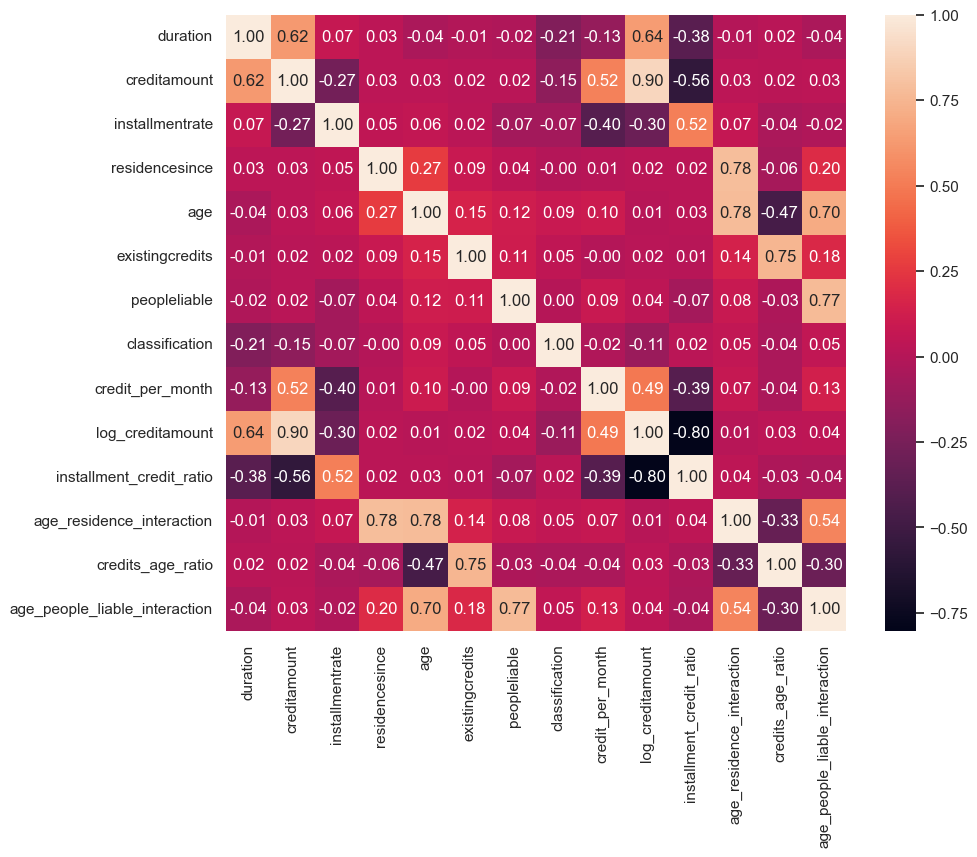

In [13]:
# Correlation between characteristics 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
correlation_matrix = data[num_vars].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()



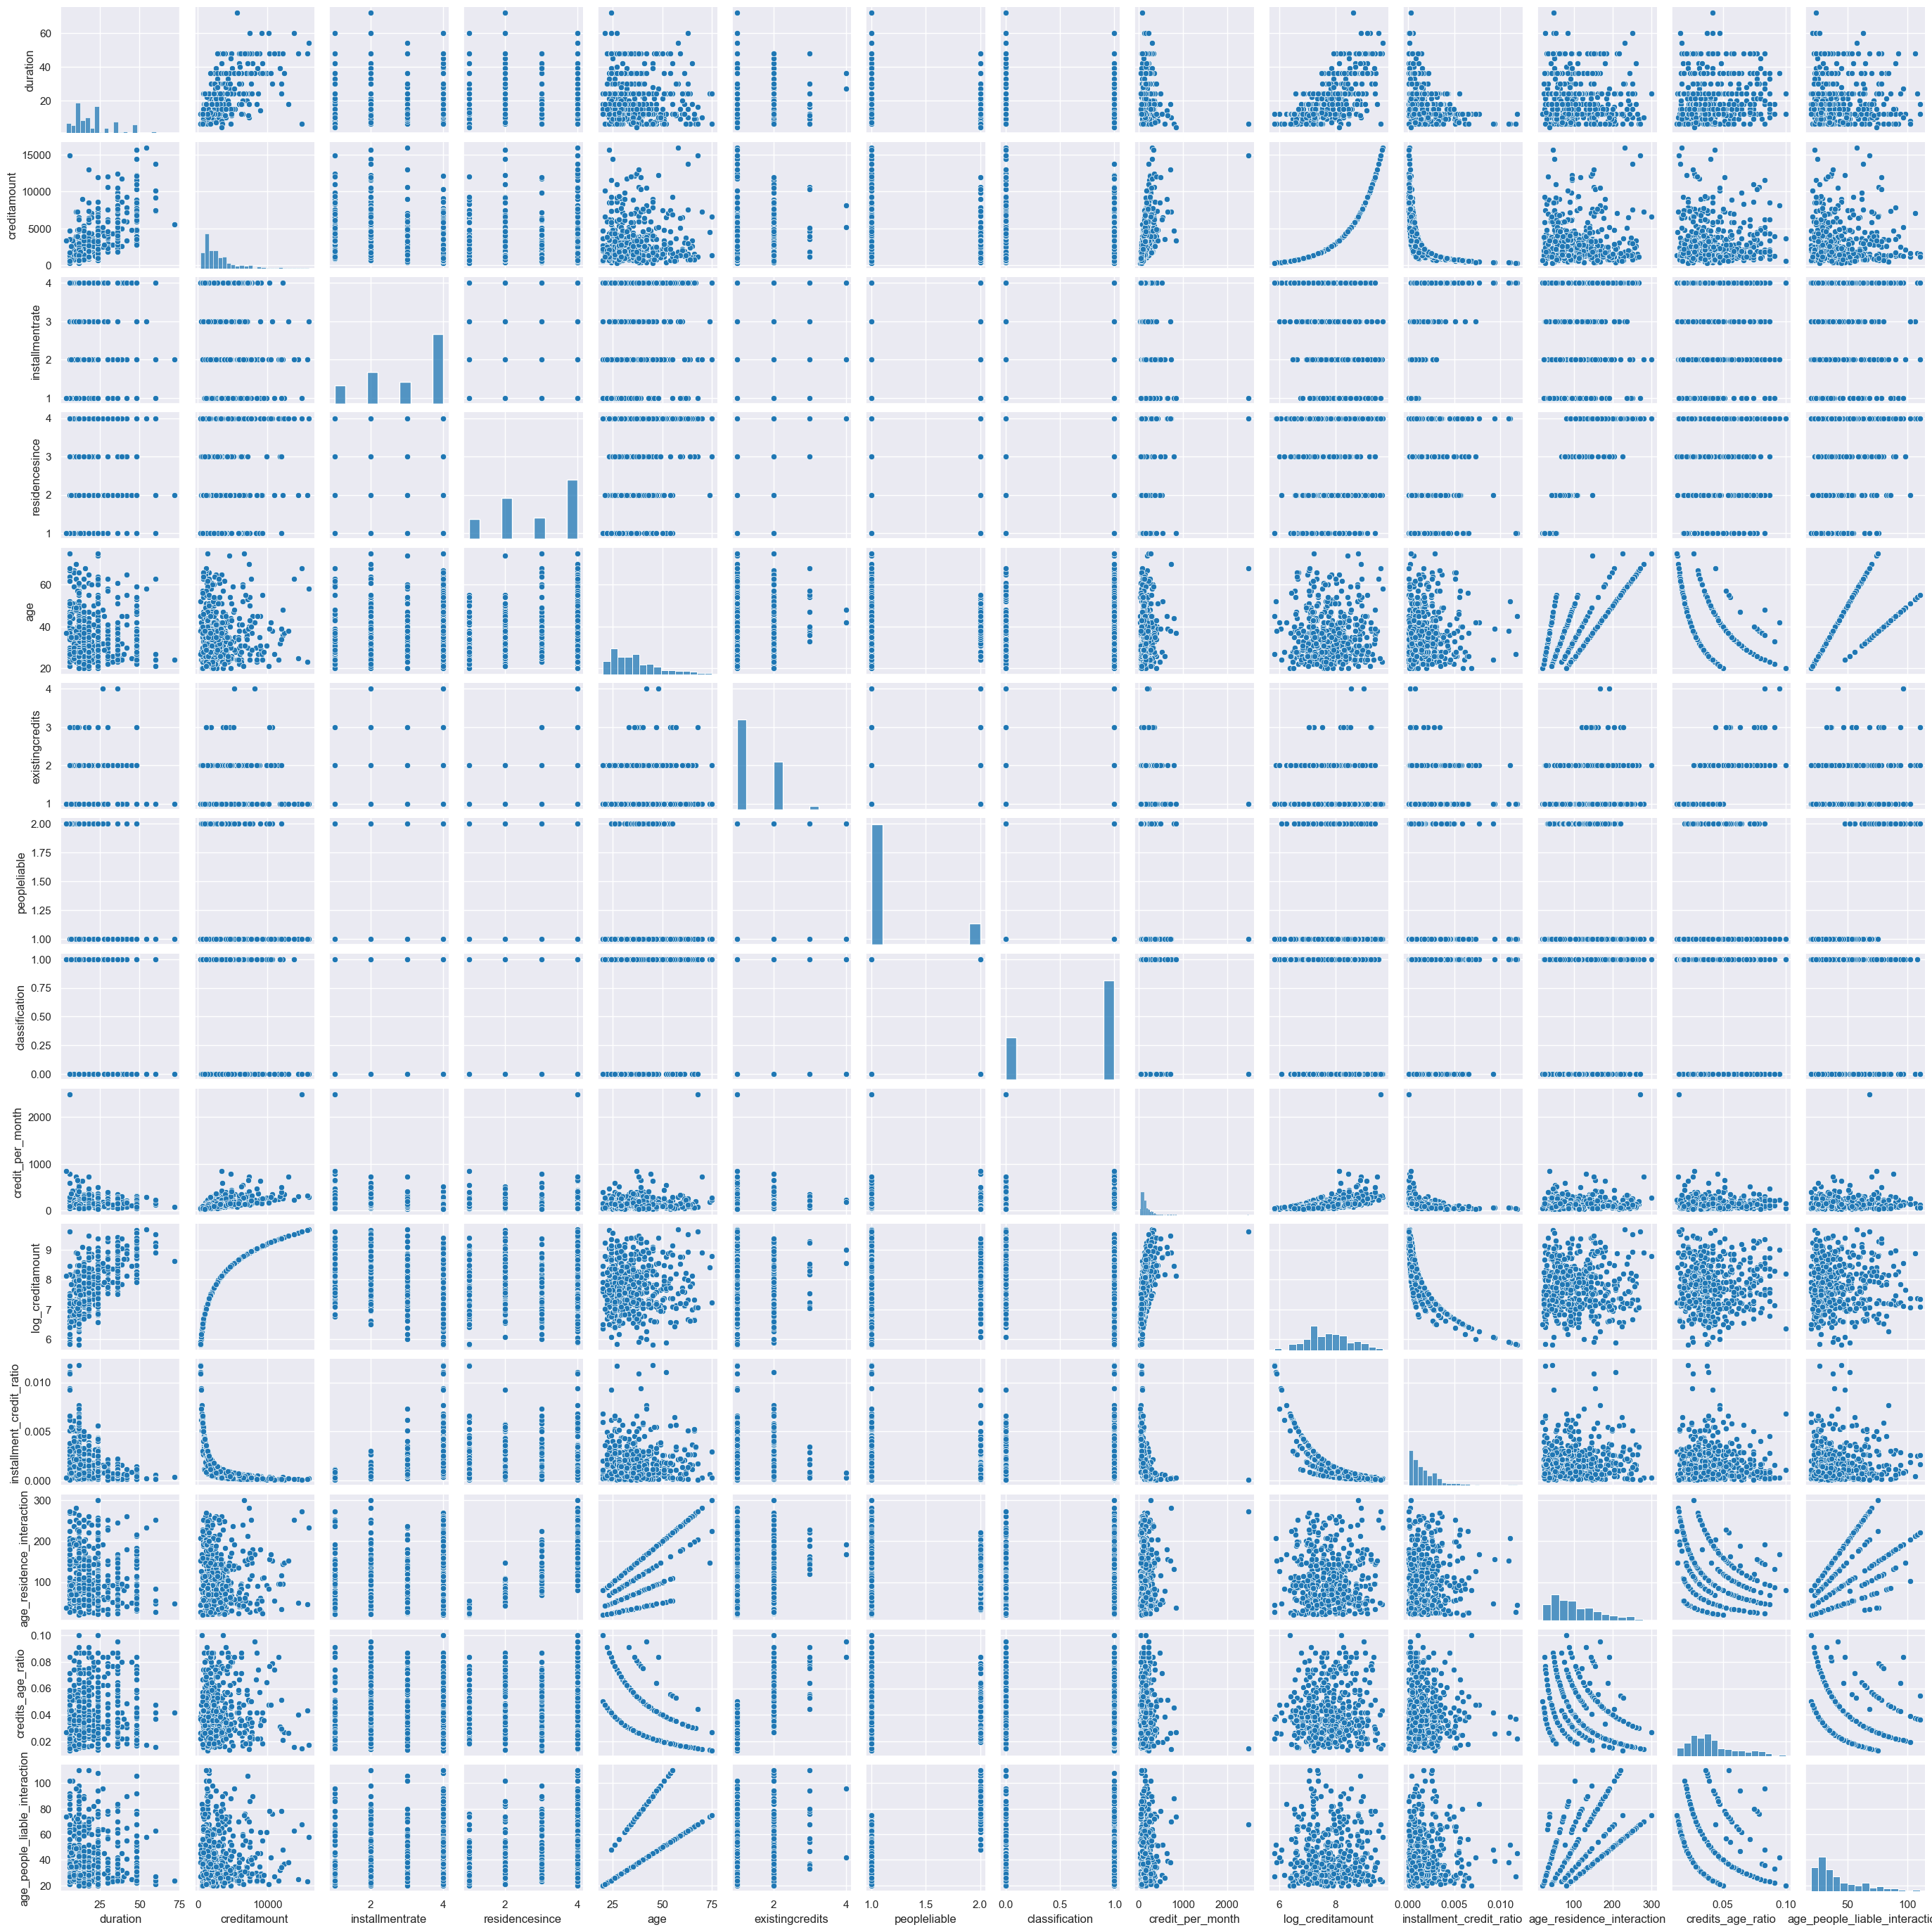

In [14]:
sns.pairplot(data[num_vars].sample(500), height=2)

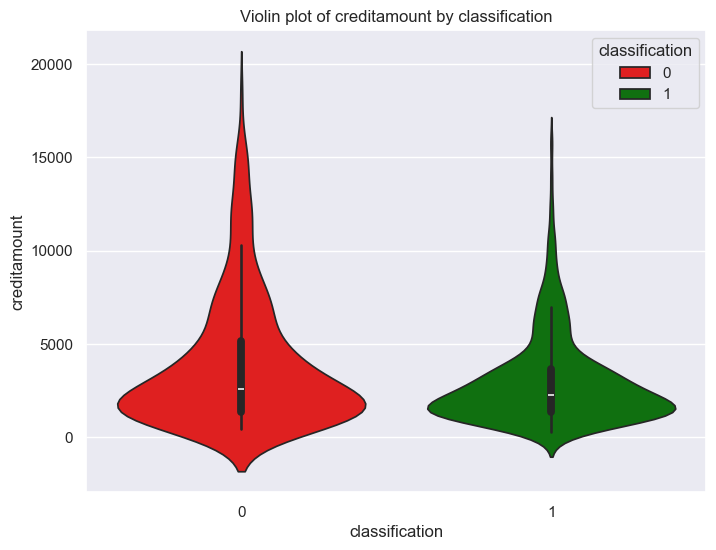

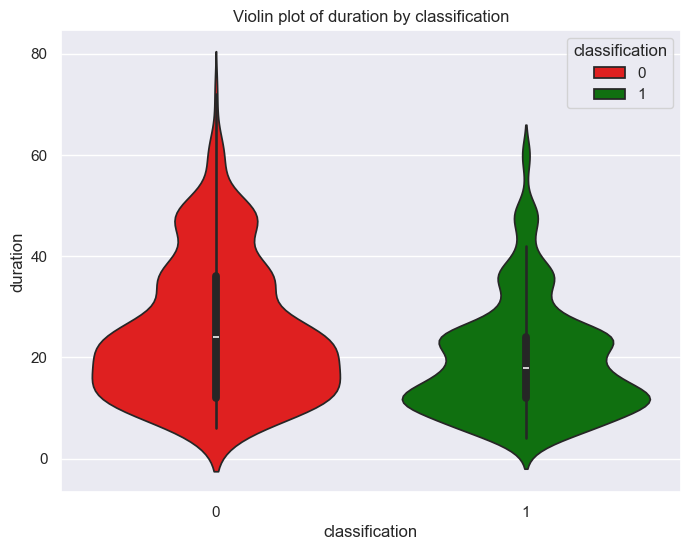

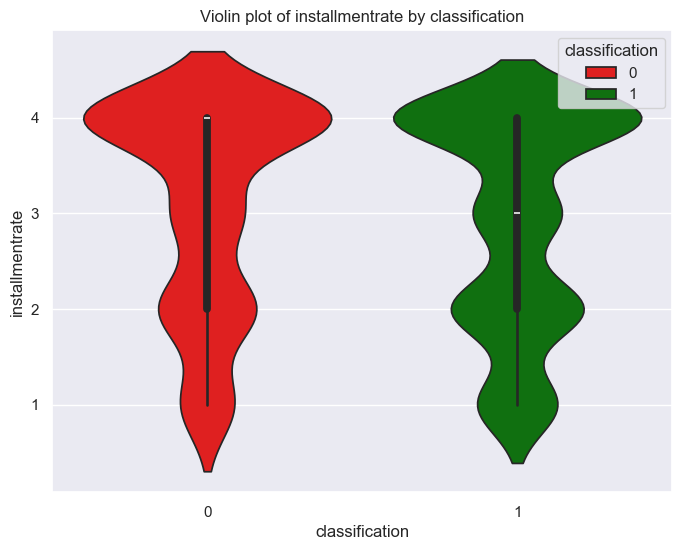

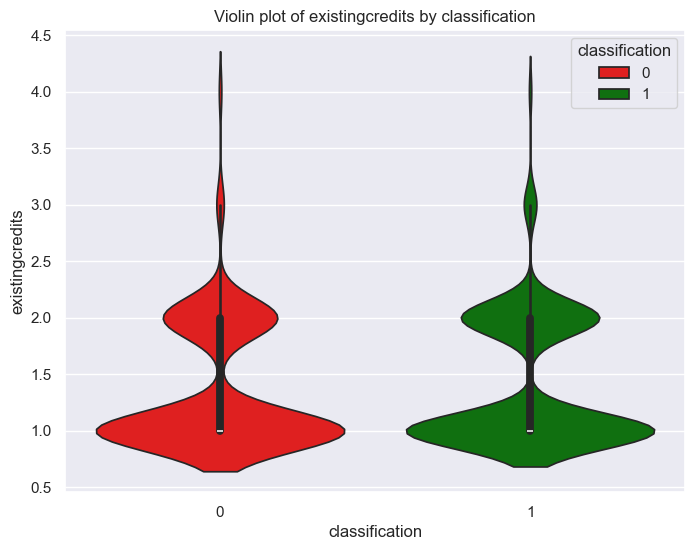

In [15]:
# Lista de variables para las cuales quieres crear gráficos de violín
vars_toplot = ['creditamount', 'duration', 'installmentrate', 'existingcredits']

# Itera a través de la lista de variables
for var in vars_toplot:
    # Crea una nueva figura para cada gráfico de violín
    plt.figure(figsize=(8, 6))  # Puedes ajustar el tamaño según tus necesidades
    # Crea el gráfico de violín con Seaborn
    sns.violinplot(x='classification', y=var, hue='classification',  data=data, palette=["red", "green"])
    # Añade un título para cada gráfico para una mejor identificación
    plt.title(f'Violin plot of {var} by classification')
    # Muestra el gráfico
    plt.show()

### StandardScaler

In [16]:
# Select categorical columns
cat_vars = data.select_dtypes(include=['object']).columns.tolist()
print(cat_vars)

['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince', 'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 'telephone', 'foreignworker']


In [17]:

# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(data[num_vars].drop(['classification'], axis=1)))

In [18]:
numdata_std.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,0.176948,-0.933901,0.929393,2.704831,-0.662251,1.278164
1,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,-0.284901,1.163046,-0.809585,-1.000190,0.157955,-0.981141
2,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,0.045495,-0.181559,-0.461231,0.703458,-1.158596,2.834573
3,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,0.130233,1.525148,-0.855986,1.249287,-1.063241,2.432919
4,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,0.229637,0.904743,-0.651820,1.778576,-0.247775,3.236227


### Encoding Categorical Feature

Labelencoding to transform categorical to numerical, Enables better Visualization than one hot encoding

In [19]:
from collections import defaultdict

#categorical variables labels
print (cat_vars)

d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = data[cat_vars].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(cat_vars)):
    print(cat_vars[x],": ", data[cat_vars[x]].unique())
    print(cat_vars[x],": ", lecatdata[cat_vars[x]].unique())

#One hot encoding, create dummy variables for every category of every categorical variable
dummy_vars = pd.get_dummies(data[cat_vars])

['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince', 'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 'telephone', 'foreignworker']
existingchecking :  ['A11' 'A12' 'A14' 'A13']
existingchecking :  [0 1 3 2]
credithistory :  ['A34' 'A32' 'A33' 'A30' 'A31']
credithistory :  [4 2 3 0 1]
purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
purpose :  [4 7 3 0 1 9 5 6 2 8]
savings :  ['A65' 'A61' 'A63' 'A64' 'A62']
savings :  [4 0 2 3 1]
employmentsince :  ['A75' 'A73' 'A74' 'A71' 'A72']
employmentsince :  [4 2 3 0 1]
statussex :  ['A93' 'A92' 'A91' 'A94']
statussex :  [2 1 0 3]
otherdebtors :  ['A101' 'A103' 'A102']
otherdebtors :  [0 2 1]
property :  ['A121' 'A122' 'A124' 'A123']
property :  [0 1 3 2]
otherinstallmentplans :  ['A143' 'A141' 'A142']
otherinstallmentplans :  [2 0 1]
housing :  ['A152' 'A153' 'A151']
housing :  [1 2 0]
job :  ['A173' 'A172' 'A174' 'A171']
job :  [2 1 3 0]
telephone :  ['A192' 

In [20]:
dummy_vars.head()

,existingchecking_A11,existingchecking_A12,existingchecking_A13,existingchecking_A14,credithistory_A30,credithistory_A31,credithistory_A32,credithistory_A33,credithistory_A34,purpose_A40,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreignworker_A201,foreignworker_A202
0,True,False,False,False,False,False,False,False,True,False,...,True,False,False,False,True,False,False,True,True,False
1,False,True,False,False,False,False,True,False,False,False,...,True,False,False,False,True,False,True,False,True,False
2,False,False,False,True,False,False,False,False,True,False,...,True,False,False,True,False,False,True,False,True,False
3,True,False,False,False,False,False,True,False,False,False,...,False,True,False,False,True,False,True,False,True,False
4,True,False,False,False,False,False,False,True,False,True,...,False,True,False,False,True,False,True,False,True,False


### Concate Transformed Dataset
append the dummy variable of the initial numerical variables numvars# append 

In [21]:
data_clean = pd.concat([data[num_vars], dummy_vars], axis = 1)

print(data_clean.shape)

(1000, 68)


In [22]:
data_clean.head()

,duration,creditamount,installmentrate,residencesince,age,existingcredits,peopleliable,classification,credit_per_month,log_creditamount,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreignworker_A201,foreignworker_A202
0,6,1169,4,4,67,2,1,1,194.833333,7.063904,...,True,False,False,False,True,False,False,True,True,False
1,48,5951,2,2,22,1,1,0,123.979167,8.691315,...,True,False,False,False,True,False,True,False,True,False
2,12,2096,2,3,49,1,2,1,174.666667,7.647786,...,True,False,False,True,False,False,True,False,True,False
3,42,7882,2,4,45,1,2,1,187.666667,8.972337,...,False,True,False,False,True,False,True,False,True,False
4,24,4870,3,4,53,2,2,0,202.916667,8.490849,...,False,True,False,False,True,False,True,False,True,False


In [23]:
data_clean_2 = data_clean.copy()
data_clean_2 = data_clean_2.drop('creditamount', axis = 1)
data_clean_2.head()

,duration,installmentrate,residencesince,age,existingcredits,peopleliable,classification,credit_per_month,log_creditamount,installment_credit_ratio,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreignworker_A201,foreignworker_A202
0,6,4,4,67,2,1,1,194.833333,7.063904,0.003422,...,True,False,False,False,True,False,False,True,True,False
1,48,2,2,22,1,1,0,123.979167,8.691315,0.000336,...,True,False,False,False,True,False,True,False,True,False
2,12,2,3,49,1,2,1,174.666667,7.647786,0.000954,...,True,False,False,True,False,False,True,False,True,False
3,42,2,4,45,1,2,1,187.666667,8.972337,0.000254,...,False,True,False,False,True,False,True,False,True,False
4,24,3,4,53,2,2,0,202.916667,8.490849,0.000616,...,False,True,False,False,True,False,True,False,True,False


In [24]:
data_clean = data_clean.drop('log_creditamount', axis = 1)
data_clean.head()

,duration,creditamount,installmentrate,residencesince,age,existingcredits,peopleliable,classification,credit_per_month,installment_credit_ratio,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreignworker_A201,foreignworker_A202
0,6,1169,4,4,67,2,1,1,194.833333,0.003422,...,True,False,False,False,True,False,False,True,True,False
1,48,5951,2,2,22,1,1,0,123.979167,0.000336,...,True,False,False,False,True,False,True,False,True,False
2,12,2096,2,3,49,1,2,1,174.666667,0.000954,...,True,False,False,True,False,False,True,False,True,False
3,42,7882,2,4,45,1,2,1,187.666667,0.000254,...,False,True,False,False,True,False,True,False,True,False
4,24,4870,3,4,53,2,2,0,202.916667,0.000616,...,False,True,False,False,True,False,True,False,True,False


### Split Training Dataset

In [25]:
# Unscaled, unnormalized data
X_clean = data_clean.drop('classification', axis=1)
y_clean = data_clean['classification']
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,y_clean,test_size=0.2, random_state=1)

In [26]:
X_train_clean.keys()

Index(['duration', 'creditamount', 'installmentrate', 'residencesince', 'age',
       'existingcredits', 'peopleliable', 'credit_per_month',
       'installment_credit_ratio', 'age_residence_interaction',
       'credits_age_ratio', 'age_people_liable_interaction',
       'existingchecking_A11', 'existingchecking_A12', 'existingchecking_A13',
       'existingchecking_A14', 'credithistory_A30', 'credithistory_A31',
       'credithistory_A32', 'credithistory_A33', 'credithistory_A34',
       'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42',
       'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46',
       'purpose_A48', 'purpose_A49', 'savings_A61', 'savings_A62',
       'savings_A63', 'savings_A64', 'savings_A65', 'employmentsince_A71',
       'employmentsince_A72', 'employmentsince_A73', 'employmentsince_A74',
       'employmentsince_A75', 'statussex_A91', 'statussex_A92',
       'statussex_A93', 'statussex_A94', 'otherdebtors_A101',
       'otherdebtors_A102', 'othe

### XGBoost  1a: Unbalance Dataset (Base Model: ROC_AUC:0.75)

Unbalanced Dataset: Train and evaluate an XGBoost model on the unbalanced dataset. Use the XGBoost classifier function with default parameters.

[0]	validation_0-auc:0.86715	validation_1-auc:0.67051
[99]	validation_0-auc:1.00000	validation_1-auc:0.73627
Confusion Matrix:
[[ 30  29]
 [ 18 123]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.51      0.56        59
           1       0.81      0.87      0.84       141

    accuracy                           0.77       200
   macro avg       0.72      0.69      0.70       200
weighted avg       0.75      0.77      0.76       200


Final Model Generalization Accuracy: 0.765000


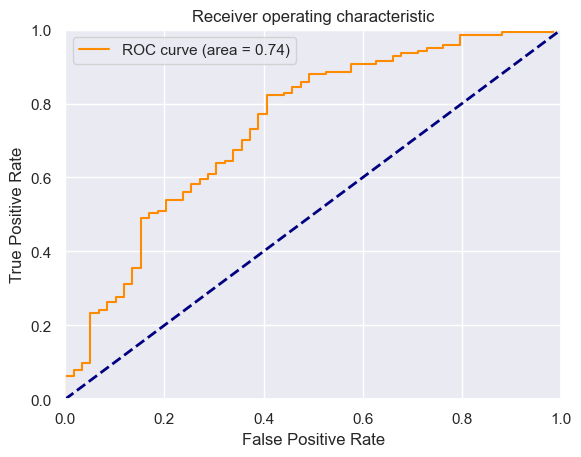

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=89, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
params={}
xgb_classifier(params, X_train_clean, y_train_clean, X_test_clean, y_test_clean)

- Test with 'log_creditamount'

In [28]:
# Unscaled, unnormalized data
X_clean_2 = data_clean_2.drop('classification', axis=1)
y_clean_2 = data_clean_2['classification']
X_train_clean_2, X_test_clean_2, y_train_clean_2, y_test_clean_2 = train_test_split(X_clean_2 ,y_clean_2,test_size=0.2, random_state=1)

[0]	validation_0-auc:0.86715	validation_1-auc:0.67051
[99]	validation_0-auc:1.00000	validation_1-auc:0.73627
Confusion Matrix:
[[ 30  29]
 [ 18 123]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.51      0.56        59
           1       0.81      0.87      0.84       141

    accuracy                           0.77       200
   macro avg       0.72      0.69      0.70       200
weighted avg       0.75      0.77      0.76       200


Final Model Generalization Accuracy: 0.765000


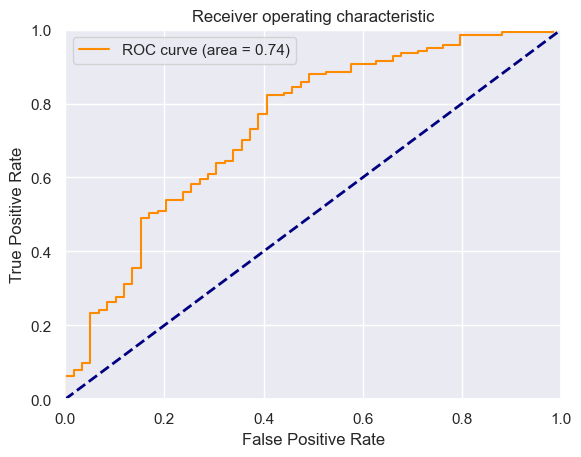

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=89, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
params={}
xgb_classifier(params, X_train_clean_2, y_train_clean_2, X_test_clean_2, y_test_clean_2)

I choose to continue the work with the first data set (data_clean) since we did not find significant differences between the original sample and the normalized sample (data_clean_2).

### XGBoost  1b: Unbalance Dataset (ROC_AUC:0.79)

Unbalanced Dataset: Train and evaluate another XGBoost model on the unbalanced dataset. Use the XGBoost classifier function with tuned parameters and Grid Search.

In [30]:
params1={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':3,
    #'seed':1024,
    'n_jobs' : -1
}

[0]	validation_0-auc:0.62131	validation_1-auc:0.60650
[100]	validation_0-auc:0.91077	validation_1-auc:0.78194
[200]	validation_0-auc:0.94111	validation_1-auc:0.78687
[268]	validation_0-auc:0.95337	validation_1-auc:0.78483
Confusion Matrix:
[[ 25  34]
 [ 14 127]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.42      0.51        59
           1       0.79      0.90      0.84       141

    accuracy                           0.76       200
   macro avg       0.71      0.66      0.68       200
weighted avg       0.75      0.76      0.74       200


Final Model Generalization Accuracy: 0.760000


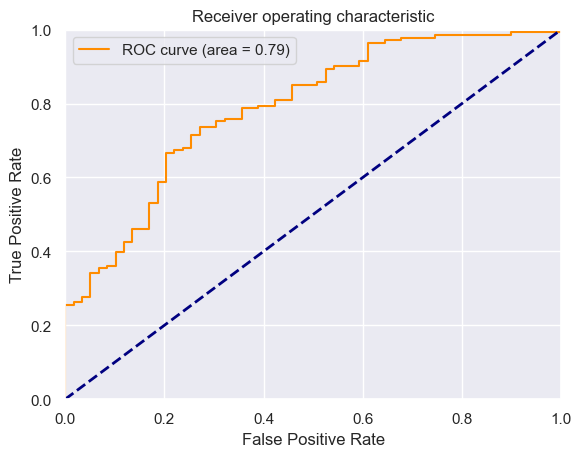

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=168, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
xgb_classifier(params1, X_train_clean, y_train_clean, X_test_clean, y_test_clean)

In [32]:
params2={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.005,
    #'gamma':0.01,
    'subsample':0.555,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'max_depth':8,
    #'seed':1024,
    'n_jobs' : -1
}

[0]	validation_0-auc:0.76638	validation_1-auc:0.63962
[100]	validation_0-auc:0.90373	validation_1-auc:0.77618
[200]	validation_0-auc:0.91880	validation_1-auc:0.78279
[300]	validation_0-auc:0.93172	validation_1-auc:0.78423
[357]	validation_0-auc:0.93959	validation_1-auc:0.78423
Confusion Matrix:
[[ 15  44]
 [  3 138]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.25      0.39        59
           1       0.76      0.98      0.85       141

    accuracy                           0.77       200
   macro avg       0.80      0.62      0.62       200
weighted avg       0.78      0.77      0.72       200


Final Model Generalization Accuracy: 0.765000


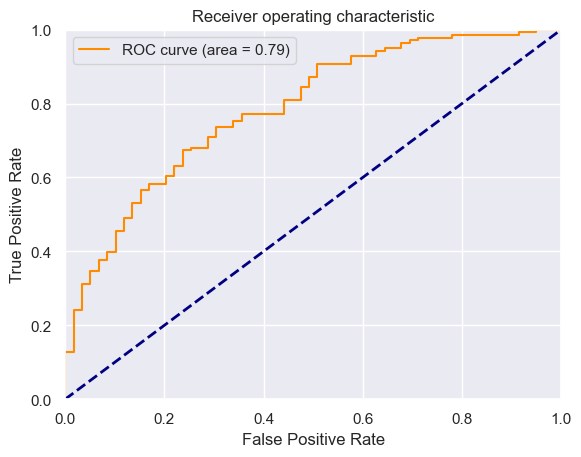

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=257, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
xgb_classifier(params2, X_train_clean, y_train_clean, X_test_clean, y_test_clean)

In [34]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [35]:
# Define the parameter search space
param_grid = {
    'n_estimators': [100, 500, 3000],  
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': [3, 5, 8],  
    'gamma': [0, 0.1],  
    'min_child_weight': [1, 3, 5],  
    'subsample': [0.6, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0],  
    'n_jobs': [-1]  # Use all available cores
}

# Create an XGBClassifier model
xgb_model = XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           cv=3,  # 3-fold cross-validation
                           scoring='roc_auc',  # Use Area Under ROC Curve as the evaluation metric
                           verbose=2,  # Show more logs
                           n_jobs=-1)  # Use all available cores

# Execute grid search
grid_search.fit(X_train_clean, y_train_clean)

# Extracting and displaying the best model, parameters, and score
best_estimator = grid_search.best_estimator_
print("Best estimator:", best_estimator)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)

best_score = grid_search.best_score_
print("Best AUC score:", best_score)


Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)
Best parameters found: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'n_jobs': -1, 'subsamp

In [36]:
best_parameters = {
    'colsample_bytree': 0.8, 
    'gamma': 0, 
    'learning_rate': 0.01, 
    'max_depth': 5, 
    'min_child_weight': 1, 
    'n_estimators': 500, 
    'n_jobs': -1, 
    'subsample': 0.6}

[0]	validation_0-auc:0.78524	validation_1-auc:0.70808
[100]	validation_0-auc:0.93327	validation_1-auc:0.77137
[200]	validation_0-auc:0.95658	validation_1-auc:0.78483
[300]	validation_0-auc:0.96911	validation_1-auc:0.78315
[311]	validation_0-auc:0.97041	validation_1-auc:0.78231
Confusion Matrix:
[[ 21  38]
 [  9 132]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.36      0.47        59
           1       0.78      0.94      0.85       141

    accuracy                           0.77       200
   macro avg       0.74      0.65      0.66       200
weighted avg       0.75      0.77      0.74       200


Final Model Generalization Accuracy: 0.765000


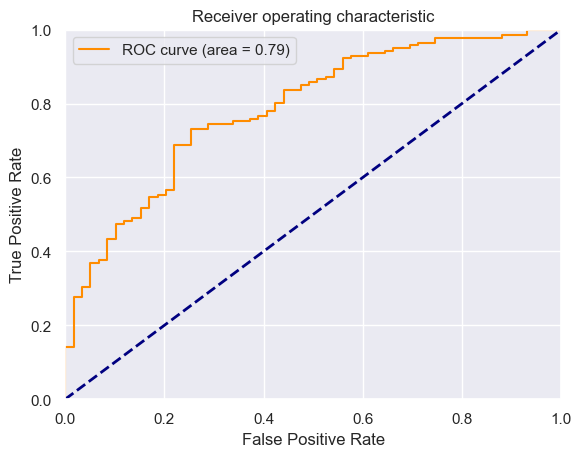

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=211, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
xgb_classifier(best_parameters, X_train_clean, y_train_clean, X_test_clean, y_test_clean)

<a id="Balanced Dataset"></a> <br>
# **3. Balanced Dataset** 

Address the class imbalance issue in the dataset by oversampling
the minority class using SMOTE (Synthetic Minority Over-sampling Technique). Apply
SMOTE to the training dataset and print the class distribution before and after
oversampling.

- XGBoost 2a: Balanced (Base Model: ROC_AUC:0.77)
- XGBoost 2b: Balanced (ROC_AUC:0.80)

In [38]:
from imblearn.over_sampling import SMOTE

In [39]:
# Oversampling

# Apply SMOTE
sm = SMOTE(sampling_strategy='auto')
X_train_clean_res, y_train_clean_res = sm.fit_resample(X_train_clean, y_train_clean)

# Print number of 'good' credits and 'bad credits, should be fairly balanced now
print("Before/After clean")
unique, counts = np.unique(y_train_clean, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_clean_res, return_counts=True)
print(dict(zip(unique, counts)))

Before/After clean
{0: 241, 1: 559}
{0: 559, 1: 559}


In [40]:
#Great, before we do anything else, let's split the data into train/test.
X_train_clean_res = pd.DataFrame(X_train_clean_res, columns=X_train_clean.keys())
#y_train_clean_res = pd.DataFrame(y_train_clean_res)

In [41]:
print(np.shape(X_train_clean_res))
print(np.shape(y_train_clean_res))
print(np.shape(X_test_clean)) 
print(np.shape(y_test_clean))

(1118, 66)
(1118,)
(200, 66)
(200,)


### XGBoost 2a: Balanced (Base Model: ROC_AUC:0.77)

Train and evaluate an XGBoost model on the balanced
dataset. Use the XGBoost classifier function with default parameters.

[0]	validation_0-auc:0.90308	validation_1-auc:0.74198
[99]	validation_0-auc:1.00000	validation_1-auc:0.73951
Confusion Matrix:
[[ 29  30]
 [ 18 123]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.49      0.55        59
           1       0.80      0.87      0.84       141

    accuracy                           0.76       200
   macro avg       0.71      0.68      0.69       200
weighted avg       0.75      0.76      0.75       200


Final Model Generalization Accuracy: 0.760000


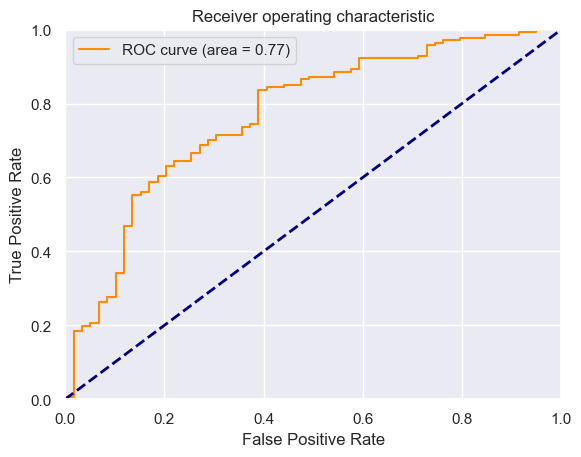

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=18, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [42]:
#BASE MODEL
params={}
xgb_classifier(params,X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### XGBoost 2b: Balanced (ROC_AUC:0.80)

Balanced Dataset: Train and evaluate another XGBoost model on the
balanced dataset. Use the XGBoost classifier function with tuned parameters.

[0]	validation_0-auc:0.85266	validation_1-auc:0.73194
[100]	validation_0-auc:0.94742	validation_1-auc:0.78627
[200]	validation_0-auc:0.95865	validation_1-auc:0.79048
[300]	validation_0-auc:0.96485	validation_1-auc:0.79300
[388]	validation_0-auc:0.97064	validation_1-auc:0.79433
Confusion Matrix:
[[ 31  28]
 [ 19 122]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        59
           1       0.81      0.87      0.84       141

    accuracy                           0.77       200
   macro avg       0.72      0.70      0.70       200
weighted avg       0.76      0.77      0.76       200


Final Model Generalization Accuracy: 0.765000


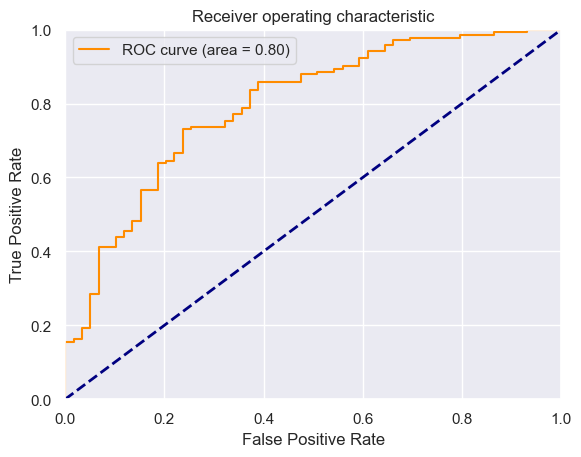

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=288, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [44]:
params = {}

params1={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':3,
    #'seed':1024,
    'n_jobs' : -1
}

params2={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.005,
    #'gamma':0.01,
    'subsample':0.555,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'max_depth':8,
    #'seed':1024,
    'n_jobs' : -1
}

#xgbclf(params, X_train, y_train,X_test,y_test)
model = xgb_classifier(params2,X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)
model
#plot_featureImportance(model, X_train_clean_res.keys())

# 4.  Feature Selection

Perform feature selection to identify the most important features.
Calculate the feature importances using the XGBoost model and select the top 10
features. Print the selected features and their importance scores.

- XGBoost3 (Base Model:ROC_AUC:0.73)
- GridSearchCV (ROC_AUC:0.70)

In [50]:
#model = xgbclf(params1,X_train_clean_res[importance_col], y_train_clean_res,X_test_clean[importance_col], y_test_clean)

importances = model.feature_importances_
importance_frame = pd.DataFrame({'Importance': list(importances), 'Feature': list(X_train_clean_res.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True, ascending=False)
importance_col = importance_frame.Feature.head(20).values

In [51]:
print(importance_col)

['existingchecking_A11' 'existingchecking_A12' 'savings_A61'
 'credithistory_A30' 'credithistory_A31' 'existingchecking_A14'
 'otherdebtors_A101' 'job_A173' 'otherdebtors_A102' 'housing_A151'
 'duration' 'purpose_A46' 'otherinstallmentplans_A142'
 'otherinstallmentplans_A141' 'purpose_A49' 'purpose_A40'
 'employmentsince_A71' 'job_A174' 'property_A124' 'employmentsince_A72']


### XGBoost3 (Base Model:ROC_AUC:0.79)

[0]	validation_0-auc:0.89481	validation_1-auc:0.74390
[99]	validation_0-auc:0.99368	validation_1-auc:0.72665
Confusion Matrix:
[[ 29  30]
 [ 13 128]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.49      0.57        59
           1       0.81      0.91      0.86       141

    accuracy                           0.79       200
   macro avg       0.75      0.70      0.72       200
weighted avg       0.77      0.79      0.77       200


Final Model Generalization Accuracy: 0.785000


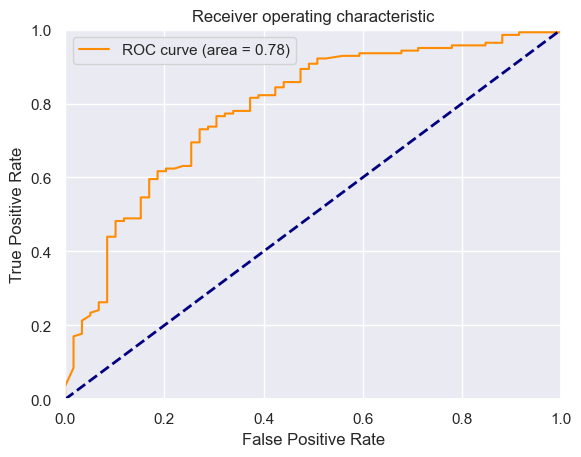

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=11, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [52]:
params = {}

params1={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.01,
    #'gamma':0.1,
    #'subsample':0.8,
    #'colsample_bytree':0.3,
    #'min_child_weight':3,
    'max_depth':3,
    #'seed':1024,
    'n_jobs' : -1
}

xgb_classifier(params,X_train_clean_res[importance_col], y_train_clean_res,X_test_clean[importance_col], y_test_clean)

### GridSearchCV (ROC_AUC:0.78)

In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:

print('XGBoost with grid search')
# play with these params
params={
    'learning_rate': [0.01, 0.02],
    'max_depth': [3, 5, 8],  
    'gamma': [0, 0.1, ], 
    'min_child_weight': [1, 3, 5], 
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'n_estimators': [50, 100, 200, 300, 400, 500,]
    #'reg_alpha': [0.03] #[0.01, 0.02, 0.03, 0.04]
}


xgb_clf = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

rs = GridSearchCV(xgb_clf,
                  params,
                  cv=3,
                  scoring="roc_auc",
                  n_jobs=-1,
                  verbose=2)

rs.fit(X_train_clean_res[importance_col], y_train_clean_res)

best_est = rs.best_estimator_
print(best_est)
best_parameters = rs.best_params_
print("Mejores parámetros encontrados: ", best_parameters)
print("Mejor puntuación AUC: ", rs.best_score_)

# Roc AUC with test data
print("Mejor puntuación AUC para el test" , rs.score(X_test_clean[importance_col],y_test_clean))


XGBoost with grid search
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)
Mejores parámetros encontrados:  {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200}
Mejor

[0]	validation_0-auc:0.92107	validation_1-auc:0.66144
[100]	validation_0-auc:0.99701	validation_1-auc:0.79937
[195]	validation_0-auc:0.99986	validation_1-auc:0.79228
Confusion Matrix:
[[ 31  28]
 [ 16 125]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.53      0.58        59
           1       0.82      0.89      0.85       141

    accuracy                           0.78       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200


Final Model Generalization Accuracy: 0.780000


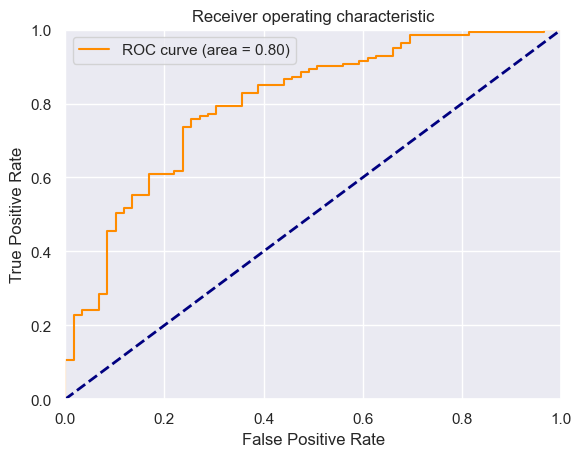

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=96, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [64]:
best_parameters = {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200}
xgb_classifier(best_parameters,X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

<a id="Others"></a> <br>
# 5. Others
- Lighgbm (ROC_AUC:0.77)
- LogisticRegression (ROC_AUC:0.75)
- RandomForestClassifier (ROC_AUC:0.80)
- ExtraTreesClassifier (ROC_AUC:0.79)
- DecisionTreeClassifier (ROC_AUC:0.69)
- GradientBoostingClassifier (ROC_AUC:0.80)
- AdaBoostClassifier (ROC_AUC:0.78)

### Lighgbm (ROC_AUC:0.77)

[LightGBM] [Info] Number of positive: 559, number of negative: 559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1438
[LightGBM] [Info] Number of data points in the train set: 1118, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBMClassifier() 



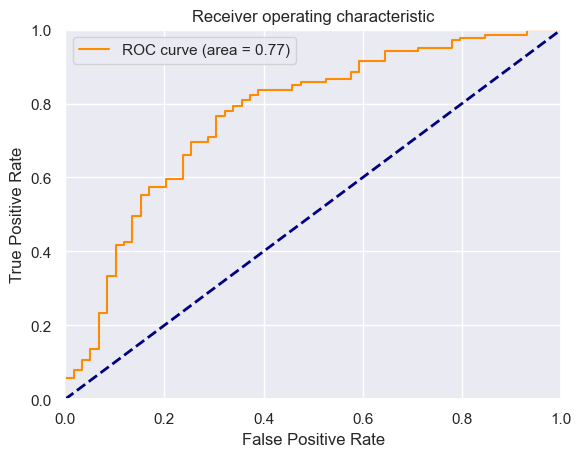

In [55]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import lightgbm as lgb

# fit, train and cross validate Decision Tree with training and test data 
def lgbclf(X_train, y_train,X_test, y_test):

    model = lgb.LGBMClassifier().fit(X_train, y_train)
    print(model,'\n')

    # Predict target variables y for test data
    y_pred = model.predict_proba(X_test)[:,1]

    # Get Cross Validation and Confusion matrix
    #get_eval(model, X_train, y_train,y_test,y_pred)
    #get_eval2(model, X_train, y_train,X_test, y_test,y_pred)
    get_roc (y_test,y_pred)
    return

# Logistic Regression
#lgbclf(X_train, y_train,X_test,y_test)
lgbclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### LogisticRegression (ROC_AUC:0.75)

LogisticRegression
LogisticRegression(max_iter=1000) 



c:\Users\Andres\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


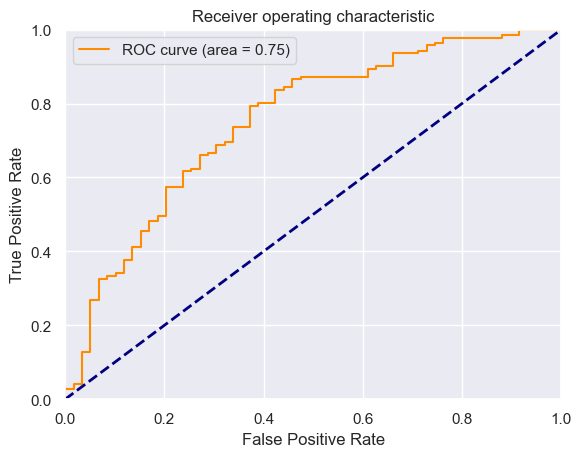

In [56]:
from sklearn.linear_model import LogisticRegression

# fit, train and cross validate Decision Tree with training and test data 
def logregclf(X_train, y_train,X_test, y_test):
    print("LogisticRegression")
    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    print(model,'\n')

    # Predict target variables y for test data
    y_pred = model.predict_proba(X_test)[:,1]

    # Get Cross Validation and Confusion matrix
    #get_eval(model, X_train, y_train,y_test,y_pred)
    #get_eval2(model, X_train, y_train,X_test, y_test,y_pred)
    get_roc (y_test,y_pred)
    return

# Logistic Regression
#logregclf(X_train, y_train,X_test,y_test)
logregclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### RandomForestClassifier (ROC_AUC:0.80)

In [81]:
from sklearn.ensemble import RandomForestClassifier 

RandomForestClassifier
RandomForestClassifier() 



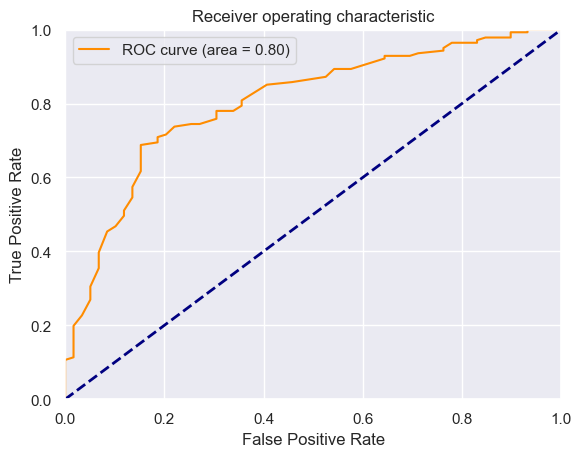

Confusion Matrix:
[[ 25  34]
 [ 15 126]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.42      0.51        59
           1       0.79      0.89      0.84       141

    accuracy                           0.76       200
   macro avg       0.71      0.66      0.67       200
weighted avg       0.74      0.76      0.74       200


Final Model Generalization Accuracy: 0.755000


RandomForestClassifier()

In [82]:


# Function to fit, train, and cross-validate Decision Tree with training and test data
def randomforestclf(X_train, y_train, X_test, y_test):
    print("RandomForestClassifier")
    
    # Fit the RandomForestClassifier with training data
    randomforest = RandomForestClassifier().fit(X_train, y_train)
    print(randomforest, '\n')
    
    # Predict target variables y for test data based on probability
    y_pred_proba = randomforest.predict_proba(X_test)[:, 1]

    # Use the custom get_roc function to generate and display the ROC curve
    get_roc(y_test, y_pred_proba)

    # Make predictions for evaluating the model
    y_pred = randomforest.predict(X_test)
    
    # Generate and print the confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion_mat)
    
    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Calculate and print the final model generalization accuracy
    print(f"\nFinal Model Generalization Accuracy: {accuracy_score(y_test, y_pred):.6f}")

    return randomforest

# Call the function with the training and testing data
randomforestclf(X_train_clean_res, y_train_clean_res, X_test_clean, y_test_clean)


### ExtraTreesClassifier (ROC_AUC:0.79)

ExtraTreesClassifier
ExtraTreesClassifier() 



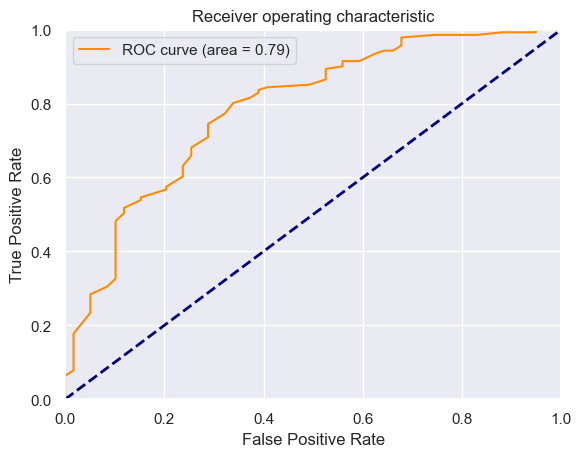

In [58]:
from sklearn.ensemble import ExtraTreesClassifier

# fit, train and cross validate Decision Tree with training and test data 
def extratreesclf(X_train, y_train,X_test, y_test):
    print("ExtraTreesClassifier")
    extratrees = ExtraTreesClassifier().fit(X_train, y_train)
    print(extratrees,'\n')
    
    # Predict target variables y for test data
    y_pred = extratrees.predict_proba(X_test)[:,1]

    # Get Cross Validation and Confusion matrix
    #get_eval(extratrees, X_train, y_train,y_test,y_pred)
    
    get_roc (y_test,y_pred)
    return
 
# Extra Trees
# Choose clean data, as tree is robust
extratreesclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### DecisionTreeClassifier (ROC_AUC:0.69)

DecisionTreeClassifier
DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=10) 



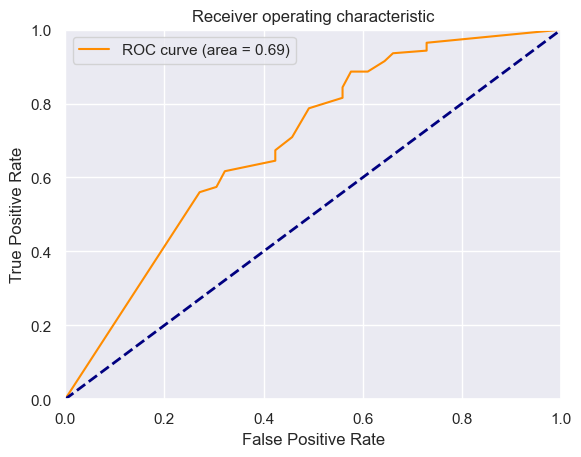

In [59]:
from sklearn.tree import DecisionTreeClassifier 
# fit, train and cross validate Decision Tree with training and test data 
def dectreeclf(X_train, y_train,X_test, y_test):
    print("DecisionTreeClassifier")
    dec_tree = DecisionTreeClassifier(min_samples_split=10,min_samples_leaf=5).fit(X_train, y_train)
    print(dec_tree,'\n')
    
    # Predict target variables y for test data
    y_pred = dec_tree.predict_proba(X_test)[:,1]

    
    # Get Cross Validation and Confusion matrix
    #get_eval(dec_tree, X_train, y_train,y_test,y_pred)
    get_roc (y_test,y_pred)
    return

# Decisiontree
dectreeclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### GradientBoostingClassifier (ROC_AUC:0.80)

In [79]:
from sklearn.ensemble import GradientBoostingClassifier


GradientBoostingClassifier
GradientBoostingClassifier() 



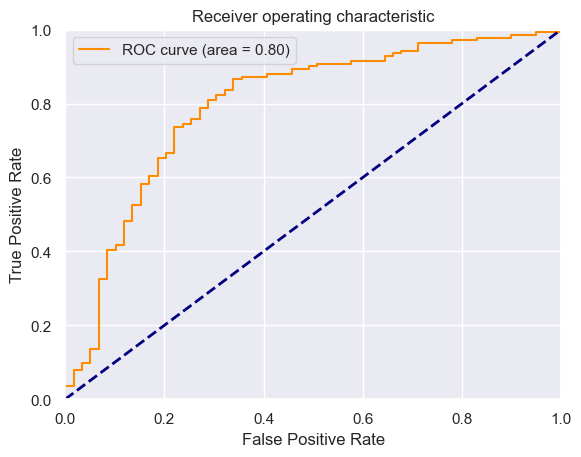

Confusion Matrix:
[[ 31  28]
 [ 15 126]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        59
           1       0.82      0.89      0.85       141

    accuracy                           0.79       200
   macro avg       0.75      0.71      0.72       200
weighted avg       0.78      0.79      0.78       200


Final Model Generalization Accuracy: 0.785000


In [78]:

# Function to fit, train, and cross-validate GradientBoostingClassifier with training and test data 
def gradientboostingclf(X_train, y_train, X_test, y_test):
    print("GradientBoostingClassifier")
    
    # Fit the GradientBoostingClassifier with training data
    gbclf = GradientBoostingClassifier().fit(X_train, y_train)
    print(gbclf, '\n')
    
    # Predict target variables y for test data based on probability
    y_pred_proba = gbclf.predict_proba(X_test)[:, 1]

    # Use the custom get_roc function to generate and display the ROC curve
    get_roc(y_test, y_pred_proba)

    # Make predictions for evaluating the model
    y_pred = gbclf.predict(X_test)
    
    # Generate and print the confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion_mat)
    
    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Calculate and print the final model generalization accuracy
    print(f"\nFinal Model Generalization Accuracy: {accuracy_score(y_test, y_pred):.6f}")

    return gbclf

# Call the function with the training and testing data
best_gb_model = gradientboostingclf(X_train_clean_res, y_train_clean_res, X_test_clean, y_test_clean)


### AdaBoostClassifier (ROC_AUC:0.78)

AdaBoostClassifier
AdaBoostClassifier() 



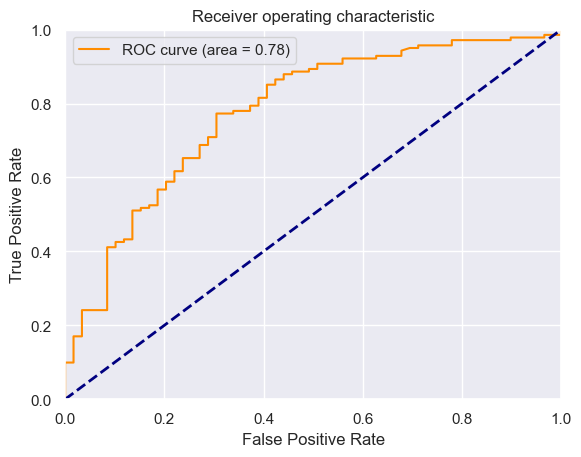

In [61]:
from sklearn.ensemble import AdaBoostClassifier

# fit, train and cross validate GradientBoostingClassifier with training and test data 
def adaboostclf(X_train, y_train, X_test, y_test):  
    print("AdaBoostClassifier")
    abclf = AdaBoostClassifier().fit(X_train, y_train)
    print(abclf,'\n')
    
    # Predict target variables y for test data
    y_pred = abclf.predict_proba(X_test)[:,1]

    # Get Cross Validation and Confusion matrix
    #get_eval(abclf, X_train, y_train,y_test,y_pred)
    get_roc (y_test,y_pred)
    return

# AdaBoostClassifier
# Choose clean data, as tree is robust
adaboostclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)


## Hyperparameterization of best "ohter" models

- Random Forest Classifier
- Gradient Boosting Classifier


### RandomizedSearchCV for the Random Forest Classifier

In [67]:
from sklearn.model_selection import RandomizedSearchCV

RandomForestClassifier
Best hyperparameters: {'n_estimators': 700, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
Confusion Matrix:
[[ 24  35]
 [ 15 126]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.41      0.49        59
           1       0.78      0.89      0.83       141

    accuracy                           0.75       200
   macro avg       0.70      0.65      0.66       200
weighted avg       0.73      0.75      0.73       200


Final Model Generalization Accuracy: 0.750000


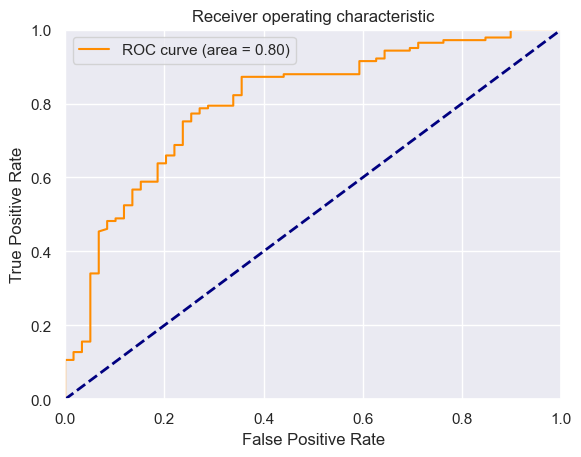

In [87]:

def randomforestclf(X_train, y_train, X_test, y_test):
    print("RandomForestClassifier")
    
    try:
        # Define the range of hyperparameters for the search
        param_distributions = {
            'n_estimators': np.arange(100, 1001, 100),  # Number of trees
            'max_depth': [None] + list(np.arange(10, 101, 10)),  # Maximum depth of the tree
            'min_samples_split': np.arange(2, 21, 2),  # Minimum number of samples required to split a node
            'min_samples_leaf': np.arange(1, 21, 2),  # Minimum number of samples required at each leaf node
            'bootstrap': [True, False]  # Method for sampling data points (with or without replacement)
        }
        
        # Initialize the RandomForest model
        randomforest = RandomForestClassifier()
        
        # Set up the hyperparameter search
        random_search = RandomizedSearchCV(
            estimator=randomforest, param_distributions=param_distributions, 
            n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42
        )
        
        # Run the hyperparameter search
        random_search.fit(X_train, y_train)
        
        # Best hyperparameter combination
        print("Best hyperparameters:", random_search.best_params_)
        
        # Best model
        model = random_search.best_estimator_
    except Exception as e:
        print(f"An error occurred during hyperparameter tuning: {e}")
        return
    
    try:
        # Make predictions and evaluate the model
        y_pred = model.predict(X_test)
        confusion_mat = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(confusion_mat)
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print(f"\nFinal Model Generalization Accuracy: {accuracy_score(y_test, y_pred):.6f}")
        
        # Predict probabilities for ROC curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        get_roc(y_test, y_pred_proba)
    except Exception as e:
        print(f"An error occurred during model evaluation: {e}")

# Use the function with the training and testing data
randomforestclf(X_train_clean_res, y_train_clean_res, X_test_clean, y_test_clean)


### RandomizedSearchCV for the Boosting Classifier

GradientBoostingClassifier
Best parameters: {'subsample': 0.6, 'n_estimators': 900, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_depth': None, 'learning_rate': 0.01}
Confusion Matrix:
[[ 28  31]
 [ 16 125]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.47      0.54        59
           1       0.80      0.89      0.84       141

    accuracy                           0.77       200
   macro avg       0.72      0.68      0.69       200
weighted avg       0.75      0.77      0.75       200


Final Model Generalization Accuracy: 0.765000


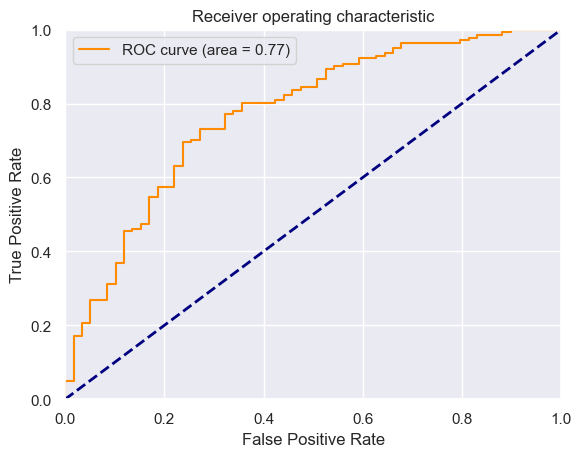

In [83]:

def gradientboostingclf(X_train, y_train, X_test, y_test):
    print("GradientBoostingClassifier")
    
    # Enhanced parameter distribution for RandomizedSearchCV
    param_dist = {
        'n_estimators': np.arange(50, 1001, 50),  # More diverse number of trees
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],  # Wider range of learning rates
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None],  # Including None for unlimited depth
        'min_samples_split': np.arange(2, 21, 1),  # Finer granularity
        'min_samples_leaf': np.arange(1, 21, 1),  # Finer granularity
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # More options for subsampling
    }
    
    # Initialize the GradientBoostingClassifier
    gbclf = GradientBoostingClassifier()
    
    # Set up the enhanced random search with more folds and iterations
    random_search = RandomizedSearchCV(
        gbclf, param_distributions=param_dist, n_iter=30,  # Increased number of iterations
        cv=5,  # Increased number of folds for cross-validation
        scoring='roc_auc', n_jobs=-1, random_state=42
    )
    
    # Fit the random search model
    random_search.fit(X_train, y_train)
    print("Best parameters:", random_search.best_params_)
    best_gbclf = random_search.best_estimator_
    
    # Make predictions and evaluate the model
    y_pred = best_gbclf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion_mat)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"\nFinal Model Generalization Accuracy: {accuracy_score(y_test, y_pred):.6f}")
    
    # Predict probabilities for ROC curve
    y_pred_proba = best_gbclf.predict_proba(X_test)[:, 1]
    # Get ROC curve
    get_roc(y_test, y_pred_proba)
    
    return best_gbclf

# Use the function with the training and testing data
best_gb_model = gradientboostingclf(X_train_clean_res, y_train_clean_res, X_test_clean, y_test_clean)
